In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda
import numpy as np
import time

In [ ]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Data augmentation to improve generalization
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

In [ ]:
def build_transfer_model():
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze the last 20 layers for fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Build model with Lambda layer for resizing
    model = models.Sequential([
        Lambda(lambda image: tf.image.resize(image, (224, 224))),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax', dtype='float32')  # Ensure output is float32
    ])
    return model

In [ ]:
def train_model(model, name, epochs=10, batch_size=64):
    # Use gradient clipping for stability
    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Learning rate scheduler to reduce LR on plateau
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    start_time = time.time()
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=[lr_scheduler],
        verbose=1
    )
    training_time = time.time() - start_time

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

    return history, test_accuracy, training_time

In [ ]:
# Train and evaluate transfer model
transfer_model = build_transfer_model()
transfer_history, transfer_accuracy, transfer_time = train_model(transfer_model, "Transfer Learning")

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 92s 87ms/step - accuracy: 0.5499 - loss: 1.6933 - val_accuracy: 0.7900 - val_loss: 0.9376 - learning_rate: 1.0000e-04
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.7544 - loss: 0.9543 - val_accuracy: 0.8198 - val_loss: 0.8202 - learning_rate: 1.0000e-04
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.7957 - loss: 0.8056 - val_accuracy: 0.8161 - val_loss: 0.8229 - learning_rate: 1.0000e-04
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.8204 - loss: 0.7127 - val_accuracy: 0.8654 - val_loss: 0.5995 - learning_rate: 1.0000e-04
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.8395 - loss: 0.6357 - val_accuracy: 0.8521 - val_loss: 0.6178 - learning_rate: 1.0000e-04
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.8553 - loss: 0.5713 - val_accuracy: 0.8482 - val_loss: 0.6609 - learning_rate: 1.0000e-04
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/ste

In [ ]:
print(f"Transfer Learning - Test Accuracy: {transfer_accuracy:.4f}")

Transfer Learning - Test Accuracy: 0.8876


In [15]:
import matplotlib.pyplot as plt

In [16]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

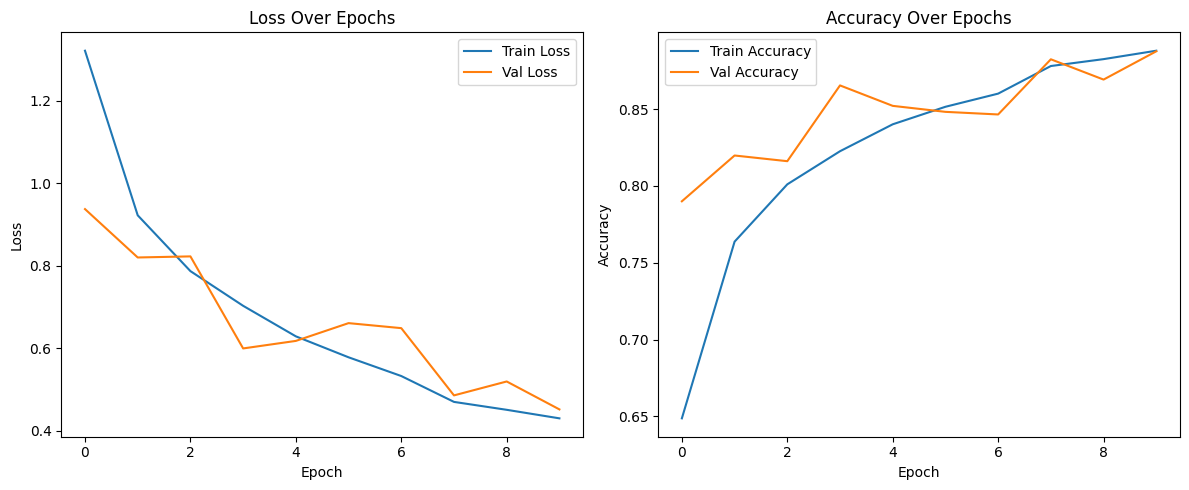

In [18]:
plot_training_history(transfer_history)